<h1> Importing Libraries </h1>

In [2]:
import torch  
import numpy as np
import wandb
import platform
import sys
from datasets import load_dataset
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, fbeta_score
from transformers import EarlyStoppingCallback
from transformers import ViTForImageClassification, AutoImageProcessor
from transformers import TrainingArguments, Trainer
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt 
import cv2
from einops import rearrange
import albumentations as A
from functools import partial
from tqdm.notebook import tqdm




In [3]:
num_classes = 3
seed = 1234
dataset_path = "pawlo2013/chest_xray"
num_of_rans = 3

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch, 'has_mps', False)
device = "mps" if getattr(torch, 'has_mps', False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if getattr(
    torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Python {sys.version}")

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")





Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.3.0
Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE


/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_82045/1284320612.py:8: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch, 'has_mps', False)
/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_82045/1284320612.py:9: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \
/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_82045/1284320612.py:11: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(


<h2> Metrics + Class Weights Calculation</h2><h2> Calculate Class Weights + Class Names</h2>

In [4]:
train_dataset = load_dataset(dataset_path, split='train')

class_names = train_dataset.features['label'].names


#delete train_dataset from memory
del train_dataset




def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    
    
    # Overall accuracy
    acc = accuracy_score(labels, preds)
    
    # Precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0) 
    
    # Confusion matrix to calculate per-class accuracy
    cm = confusion_matrix(labels, preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    # Prepare the per-class accuracy in a dictionary
    per_class_accuracy = {f"accuracy_class_{class_names[i]}": acc for i, acc in enumerate(per_class_acc)}
    
    # Combine all metrics into one dictionary
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    metrics.update(per_class_accuracy)

    # log the confusion matrix to W&B

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                             y_true=labels,
                                                          preds=preds,
                                                           class_names=class_names)})    

    
    return metrics
   

def calculate_class_weights(dataset_path, device):
    # Load the dataset
    dataset = load_dataset(dataset_path)
    
    # Assuming the label column is named 'label'
    train_labels = dataset['train']['label']
    
    # Count the number of samples in each class
    label_counts = Counter(train_labels)
    
    # Get total number of samples
    total_samples = len(train_labels)
    
    # Calculate class weights: inverse of class frequency
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    
    # Convert class weights to tensor and move to the specified device
    class_weights_tensor = torch.tensor(
        [class_weights[label] for label in range(len(class_weights))],
        dtype=torch.float
    ).to(device)
    
    return class_weights_tensor

class_weights = calculate_class_weights(dataset_path, device)


<h2 style='color:orange'> Finetune Vision Transformer all layers (processor, transform, collate_function) </h2>


In [5]:


model_name_or_path = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_name_or_path)


def transform(example_batch, processor):

    inputs = processor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')
    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }




train_tranform = partial(transform, processor=processor)
validation_and_train_tranform = partial(transform, processor=processor)


train_dataset = load_dataset(dataset_path, split='train')
validation_dataset = load_dataset(dataset_path, split='validation')
test_dataset = load_dataset(dataset_path, split='test')
prepared_dataset_train_vision_transformer = train_dataset.with_transform(train_tranform)
prepared_dataset_validation_vision_transformer = validation_dataset.with_transform(validation_and_train_tranform)
prepared_dataset_test_vision_transformer = test_dataset.with_transform(validation_and_train_tranform)



labels = class_names




def model_init(trial):

    model_name_or_path = "google/vit-base-patch16-224-in21k"

    return ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),


)

/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<h3> We have to write a custom Trainer in order to have our precious class weights 
 </h3>

In [6]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

<h2 style="color:orange"> Hyper Parameter Search Full Model</h2>

In [ ]:
def wandb_hp_space(trial):
    return {
        "method": "bayes",
        "metric": {"name": "objective", "goal": "minimize"},
        "parameters": {
            "learning_rate": {"distribution": "uniform", "min": 1e-6, "max": 1e-4},
            "per_device_train_batch_size": {"values": [8, 16, 32]},

        },
    }


training_args = TrainingArguments(
      output_dir="./wandb_sweeps",
      evaluation_strategy="steps",
      num_train_epochs=5,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      save_total_limit=1,
      remove_unused_columns=False,
      metric_for_best_model="eval_loss",
      push_to_hub=False,
      report_to=None,
      load_best_model_at_end=True,
    )

trainer = CustomTrainer(
        model_init=model_init,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_dataset_train_vision_transformer,
        eval_dataset=prepared_dataset_validation_vision_transformer,
        tokenizer=processor,
    )




best_trial = trainer.hyperparameter_search(direction="minimize", backend='wandb', n_trials=20, hp_space=wandb_hp_space)




<h2> Extract best hyperparameters </h2> 

In [10]:
def extract_parameters(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    learning_rate = None
    batch_size = None

    for line in lines:
        if "Best learning rate" in line:
            learning_rate = float(line.split(":")[1].strip())
        elif "Best per_device_train_batch_size" in line:
            batch_size = int(line.split(":")[1].strip())

    return learning_rate, batch_size

In [11]:

file_path = "best_hyperparameters_full_model.txt"


try:
    hyperparameter = best_trial.hyperparameters
    learning_rate = hyperparameter["learning_rate"]
    per_device_train_batch_size = hyperparameter["per_device_train_batch_size"]
    #save to file # make sure that the file is created if it does not exist

    with open(file_path, 'w') as file:
        file.write(f"Best learning rate: {learning_rate}\n")
        file.write(f"Best per_device_train_batch_size: {per_device_train_batch_size}\n")

except NameError:
    learning_rate, per_device_train_batch_size = extract_parameters(file_path)
    





print(f"Best learning rate: {learning_rate}")
print(f"Best per_device_train_batch_size: {per_device_train_batch_size}")

Best learning rate: 2.925644191862583e-06
Best per_device_train_batch_size: 32


<h2 style='color:orange'> Training </h2>

In [ ]:
for i in range(num_of_rans):
    wandb.init(project="vit-pneumonia-x-ray_no_data_augmentation", 
               name=f"vit-pneumonia-x-ray-run-{i}", config={
                   "model_name": model_name_or_path,
                   "batch_size": per_device_train_batch_size,
                   "num_classes": num_classes,
                   "seed": seed,
                   "dataset_path": dataset_path,
                   "num_of_rans": num_of_rans
               })


    training_args = TrainingArguments(
      output_dir="./vit-pneumonia-x-ray",
      per_device_train_batch_size=per_device_train_batch_size,
      per_device_eval_batch_size=per_device_train_batch_size,
      evaluation_strategy="steps",
      num_train_epochs=50,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      learning_rate=learning_rate,
      save_total_limit=1,
      remove_unused_columns=False,
      metric_for_best_model="eval_loss",
      push_to_hub=False,
      report_to='wandb',
      load_best_model_at_end=True,
    )

    trainer = CustomTrainer(
        model_init=model_init,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_dataset_train_vision_transformer,
        eval_dataset=prepared_dataset_validation_vision_transformer,
        tokenizer=processor,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
    )

    trainer.train()

    trainer.evaluate(prepared_dataset_test_vision_transformer, metric_key_prefix="test")

    



In [ ]:

trainer.save_model()
trainer.save_state()




<h2 style='color:orange'> Evaluation On Test Set </h2> 

In [12]:
full_train_model = ViTForImageClassification.from_pretrained("./vit-pneumonia-x-ray/checkpoint-2100", num_labels=num_classes)

training_args = TrainingArguments(
      output_dir="./vit-pneumonia-x-ray_full_test",
      per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
      evaluation_strategy="steps",
      num_train_epochs=50,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      learning_rate=learning_rate,
      save_total_limit=1,
      remove_unused_columns=False,
      metric_for_best_model="eval_loss",
      push_to_hub=False,
      report_to=None,
      load_best_model_at_end=True,
    )

wandb.init(project="test")
full_trainer = CustomTrainer(
        model=full_train_model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_dataset_train_vision_transformer,
        eval_dataset=prepared_dataset_validation_vision_transformer,
        tokenizer=processor,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
    )

full_trainer.evaluate(prepared_dataset_test_vision_transformer)
    

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pawelpiwowarski2000. Use `wandb login --relogin` to force relogin


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.7469778060913086,
 'eval_accuracy': 0.7627986348122867,
 'eval_precision': 0.8272981160430632,
 'eval_recall': 0.7627986348122867,
 'eval_f1': 0.7594879008307032,
 'eval_accuracy_class_Bacterial': 0.9678899082568807,
 'eval_accuracy_class_Normal': 0.5384615384615384,
 'eval_accuracy_class_Viral': 0.8208955223880597,
 'eval_runtime': 29.7931,
 'eval_samples_per_second': 19.669,
 'eval_steps_per_second': 1.242}

In [30]:
def test_per_layer_accuracy(model, test_dataset, device, pool="cls"):
    # Put the model in evaluation
    model.eval()

    # Move the model to the specified device
    model.to(device)
    
    #print the 
    # Create a DataLoader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

    print('The number of transformer blocks in the model is:', model.config.num_hidden_layers)

    # Initialize a dictionary to store the number of correct predictions per layer
    correct_per_layer = {f"block_{i}": 0 for i in range(model.config.num_hidden_layers + 1)}
    correct_per_layer["classifier"] = 0

    # Initialize a dictionary to store the total number of samples per layer
    total_per_layer = {f"block_{i}": 0 for i in range(model.config.num_hidden_layers + 1)}
    total_per_layer["classifier"] = 0   

    # Iterate over the test dataset

    for batch in tqdm(test_loader, desc="Testing per block accuracy"): 

        image = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(image, labels=labels, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            for i, hidden_state in enumerate(hidden_states):
                 # here we are taking the CLS token representation assuming cls pooling
                 # since this is the form of pooling used in the classification head (original ViT)

                if pool == "cls":
                    # check whether this is the last layer
                    cls_token_representation = hidden_state[:, 0, :]
                elif pool == "mean":
                    cls_token_representation = hidden_state.mean(dim=1)

                else:
                    raise ValueError("Invalid pooling method. Use 'cls' or 'mean'")

                
                logits = model.classifier(cls_token_representation) 

                # Compute the predictions
                preds = torch.argmax(logits, dim=1)
     

                # Update the correct predictions and total samples for this layer
                correct_per_layer[f"block_{i}"] += (preds == labels).sum().item()
                total_per_layer[f"block_{i}"] += labels.size(0)
            
            final_preds = torch.argmax(outputs.logits, dim=1)
            correct_per_layer["classifier"] += (final_preds == labels).sum().item()
            total_per_layer["classifier"] += labels.size(0)


    # Calculate accuracy for each layer
    accuracies = {layer: correct / total_per_layer[layer] for layer, correct in correct_per_layer.items()}

    accuracies["classifier"] = correct_per_layer["classifier"] / total_per_layer["classifier"]

    return accuracies



test_per_layer_accuracy(full_train_model, prepared_dataset_test_vision_transformer, device, pool="cls")

The number of transformer blocks in the model is: 12


Testing per block accuracy:   0%|          | 0/37 [00:00<?, ?it/s]

{'block_0': 0.3993174061433447,
 'block_1': 0.3993174061433447,
 'block_2': 0.19965870307167236,
 'block_3': 0.3993174061433447,
 'block_4': 0.40273037542662116,
 'block_5': 0.4232081911262799,
 'block_6': 0.49146757679180886,
 'block_7': 0.5597269624573379,
 'block_8': 0.5767918088737202,
 'block_9': 0.6023890784982935,
 'block_10': 0.7098976109215017,
 'block_11': 0.7013651877133106,
 'block_12': 0.7627986348122867,
 'classifier': 0.7627986348122867}

Samples found for all classes!


/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_50439/288853805.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


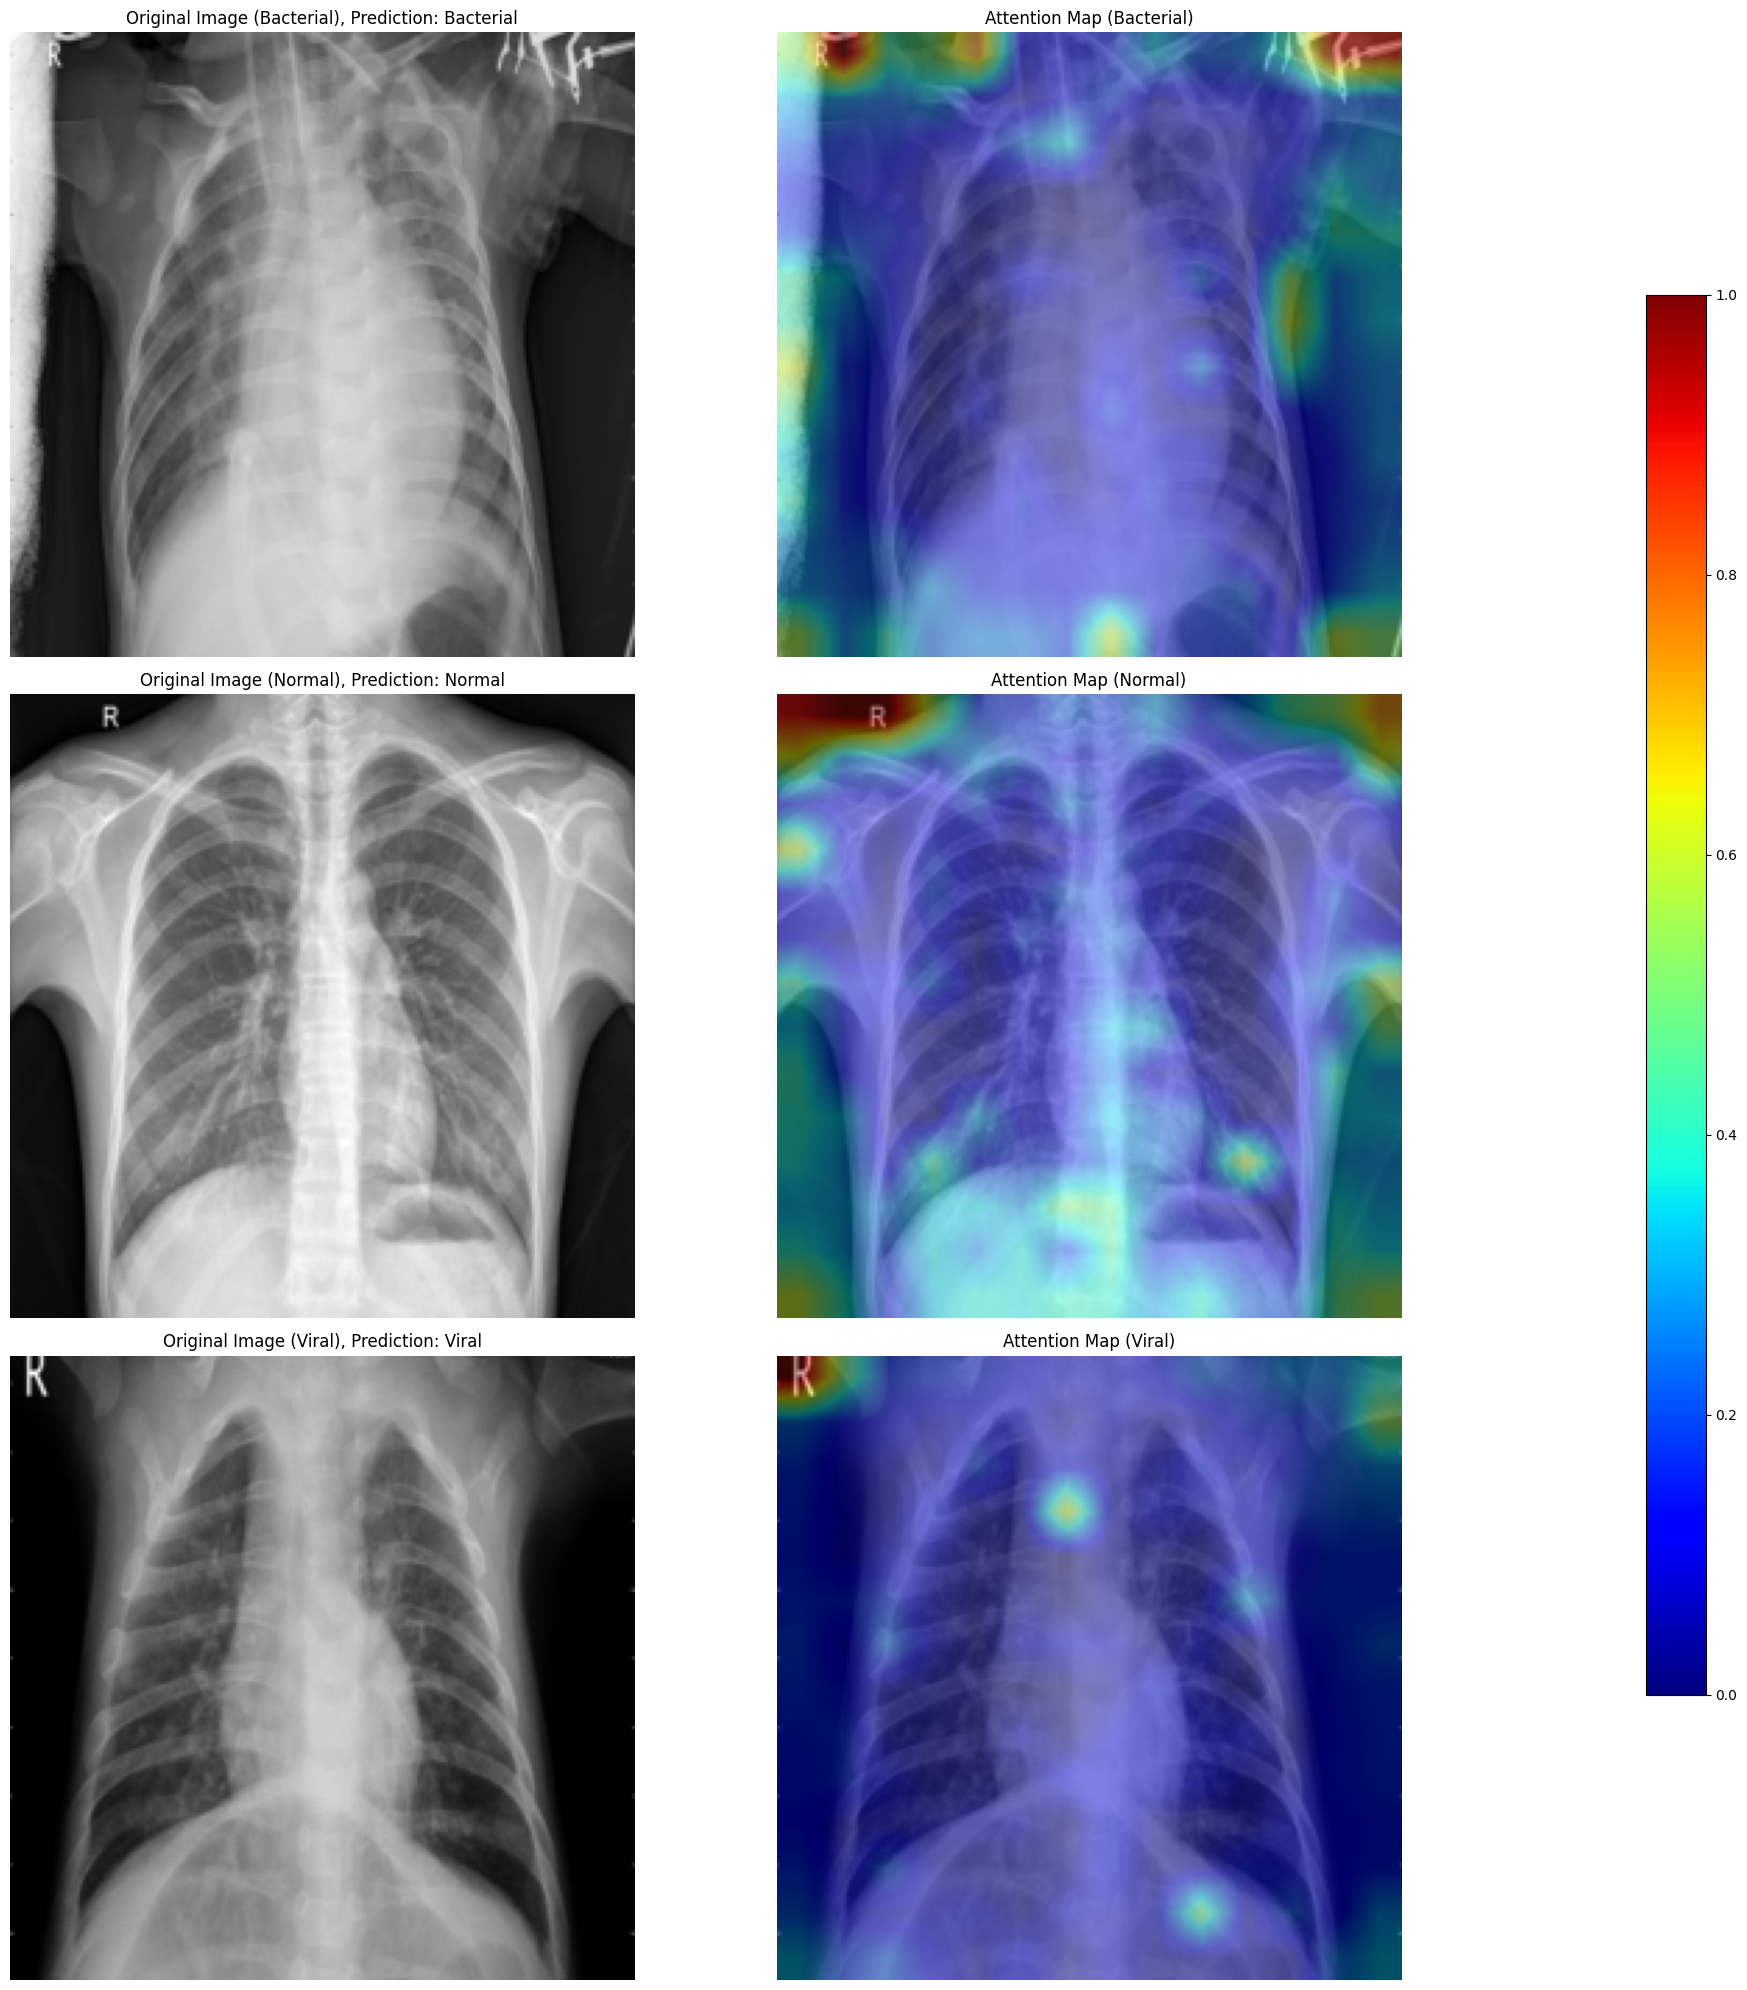

In [16]:

def show_final_layer_attention_maps(model, test_dataset, device, discard_ratio=0.9, head_fusion="mean"):
    # Put the model in evaluation mode
    model.eval()

    # Move the model to the specified device
    model.to(device)

    # Create a DataLoader with batch size equal to the number of images
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

    class_names = test_dataset.features['label'].names

    samples = [None] * 3  # Initialize list to store samples for each class

    for batch in test_loader:
        images, labels = batch['pixel_values'].to(device), batch['labels'].to(device)

        for image, label in zip(images, labels):
            # Check if a sample for the current class has already been found
            if samples[label] is None:
                samples[label] = image

        # Check if samples for all classes have been found
        if all(sample is not None for sample in samples):
            break
    
    print("Samples found for all classes!")

    # Create a figure to plot the attention maps
    fig, axs = plt.subplots(3, 2, figsize=(20, 20))

    # Iterate over the samples
    with torch.no_grad():
        for i, image in enumerate(samples):
            
            label = class_names[i]

            # Forward pass through the model
            outputs = model(image.unsqueeze(0), output_attentions=True)

            prediciton = torch.argmax(outputs.logits, dim=-1).item()

            predicted_class = class_names[prediciton]

            #scale image to [0, 1]
            image = image - image.min()
            image = image / image.max()

            # Plot the original image

            axs[i, 0].imshow(image.permute(1, 2, 0).cpu())
            axs[i, 0].axis('off')
            axs[i, 0].set_title(f"Original Image ({label}), Prediction: {predicted_class}")

            # Initialize the result tensor and recursively fuse the attention maps
            result = torch.eye(outputs.attentions[0].size(-1)).to(device)

            for attention in outputs.attentions:
                if head_fusion == "mean":
                    attention_heads_fused = attention.mean(axis=1)
                elif head_fusion == "max":
                    attention_heads_fused = attention.max(axis=1)[0]
                elif head_fusion == "min":
                    attention_heads_fused = attention.min(axis=1)[0]

                flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)

                _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
                indices = indices[indices != 0]
                flat[0, indices] = 0

                I = torch.eye(attention_heads_fused.size(-1)).to(device)
                a = (attention_heads_fused + 1.0*I)/2
                a = a / a.sum(dim=-1)

                result = torch.matmul(a, result)

            mask = result[0, 0, 1:]
            # In case of 224x224 image, this brings us from 196 to 14
            width = int(mask.size(-1)**0.5)
            mask = mask.reshape(width, width).cpu().numpy()
            mask = mask / np.max(mask)

            mask = cv2.resize(mask, (224, 224))

            # Normalize mask to [0, 1] for visualization
            mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
            heatmap = plt.cm.jet(mask)[:, :, :3]  # Apply colormap

            # Superimpose heatmap on the original image
            showed_img = image.permute(1, 2, 0).cpu().numpy()
            showed_img = (showed_img - np.min(showed_img)) / (np.max(showed_img) - np.min(showed_img))  # Normalize image
            superimposed_img = heatmap * 0.4 + showed_img * 0.6  # Combine heatmap with original image

            # Plot attention map
            axs[i, 1].imshow(superimposed_img)
            axs[i, 1].axis('off')
            axs[i, 1].set_title(f"Attention Map ({label})")

        # Create colorbar as a separate axes
        cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Position of the colorbar
        norm = plt.Normalize(vmin=0, vmax=1)
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        fig.colorbar(sm, cax=cbar_ax)

        plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
        plt.show()

# Example usage:
show_final_layer_attention_maps(full_train_model, prepared_dataset_test_vision_transformer, device, discard_ratio=0.7, head_fusion="max")


<h2> Get Stats like per class accuracy, total accuracy, precision recall from the wandb run</h2>

In [30]:
from collections import defaultdict
from scipy import stats
import pandas as pd


api = wandb.Api()


#dictionary to store the results 




def get_stats(wandb_project_name):



    results = defaultdict(list) 

    project_runs = api.runs(wandb_project_name)

    print(f"Number of runs in project {wandb_project_name}: {len(project_runs)}")


    for run in project_runs:

        test_accuracy = run.summary.get("test/accuracy")
        test_precision = run.summary.get("test/precision")
        test_recall = run.summary.get("test/recall")
        test_f1 = run.summary.get("test/f1")
        bacterial_accuracy = run.summary.get("test/accuracy_class_Bacterial")
        viral_accuracy = run.summary.get("test/accuracy_class_Viral")
        normal_accuracy = run.summary.get("test/accuracy_class_Normal")

        results["test_accuracy"].append(test_accuracy)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        results["bacterial_accuracy"].append(bacterial_accuracy)
        results["viral_accuracy"].append(viral_accuracy)
        results["normal_accuracy"].append(normal_accuracy)


    return results


def make_table_with_mean_and_sd(results_dict):
    results_df = pd.DataFrame(results_dict)
    
    # Calculate the mean and standard deviation
    mean_values = results_df.mean()
    std_values = results_df.std()
    
    # Combine the results into one DataFrame
    results_with_mean_and_sd = pd.concat([mean_values, std_values], axis=1)
    results_with_mean_and_sd.columns = ["mean", "standard_deviation"]
    
    return results_with_mean_and_sd

results = get_stats("vit-pneumonia-x-ray_no_data_augmentation")

print(results)

table = make_table_with_mean_and_sd(results)

print(table)


        

Number of runs in project vit-pneumonia-x-ray_no_data_augmentation: 3
defaultdict(<class 'list'>, {'test_accuracy': [0.7627986348122867, 0.7627986348122867, 0.7627986348122867], 'test_precision': [0.8272981160430632, 0.8272981160430632, 0.8272981160430632], 'test_recall': [0.7627986348122867, 0.7627986348122867, 0.7627986348122867], 'test_f1': [0.7594879008307032, 0.7594879008307032, 0.7594879008307032], 'bacterial_accuracy': [0.9678899082568808, 0.9678899082568808, 0.9678899082568808], 'viral_accuracy': [0.8208955223880597, 0.8208955223880597, 0.8208955223880597], 'normal_accuracy': [0.5384615384615384, 0.5384615384615384, 0.5384615384615384]})
                        mean  standard_deviation
test_accuracy       0.762799        0.000000e+00
test_precision      0.827298        1.359740e-16
test_recall         0.762799        0.000000e+00
test_f1             0.759488        1.359740e-16
bacterial_accuracy  0.967890        0.000000e+00
viral_accuracy      0.820896        0.000000e+00
nor

<h2 style='color:orange'>  Test with no finetuning at all </h2>

In [35]:
fresh_model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=num_classes,

)   

test_per_layer_accuracy(fresh_model, prepared_dataset_test_vision_transformer, device)





  



    


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The number of transformer blocks in the model is: 12


Testing per block accuracy:   0%|          | 0/37 [00:00<?, ?it/s]

{'block_0': 0.22866894197952217,
 'block_1': 0.257679180887372,
 'block_2': 0.257679180887372,
 'block_3': 0.30204778156996587,
 'block_4': 0.3703071672354949,
 'block_5': 0.378839590443686,
 'block_6': 0.37372013651877134,
 'block_7': 0.32081911262798635,
 'block_8': 0.29692832764505117,
 'block_9': 0.2508532423208191,
 'block_10': 0.3361774744027304,
 'block_11': 0.34982935153583616,
 'block_12': 0.3651877133105802,
 'classifier': 0.3720136518771331}

wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
model_name_or_path = "google/vit-base-patch16-224-in21k"

not_frozen_layers = ["encoder.layer.11", "vit.layernorm.weight", "vit.layernorm.bias", "classifier.weight", "classifier.bias"]

frozen_model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    )

for name, param in frozen_model.named_parameters():
        if all(not_frozen_layer not in name for not_frozen_layer in not_frozen_layers):
            param.requires_grad = False

print("Number of trainable parameters:", sum(p.numel() for p in frozen_model.parameters() if p.requires_grad))

for name, param in frozen_model.named_parameters():
    print(name, param.requires_grad)


<h2 style='color:orange'>  Model with 11 layers frozen </h2>

In [ ]:
def frozen_model_init(trial):

    model_name_or_path = "google/vit-base-patch16-224-in21k"

    not_frozen_layers = ["encoder.layer.11", "vit.layernorm.weight", "vit.layernorm.bias", "classifier.weight", "classifier.bias"]

    frozen_model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    )

    # Freeze all layers except the last one
    for name, param in frozen_model.named_parameters():
        if all(not_frozen_layer not in name for not_frozen_layer in not_frozen_layers):
            param.requires_grad = False
    
    return frozen_model





    


<h2> Full Train 11 layers frozen</h2>

In [ ]:

num_of_rans = 4

for i in range(num_of_rans):

    wandb.init(project="vit-pneumonia-x-ray_no_data_augmentation_frozen_except_last", 
                name=f"vit-pneumonia-x-ray-run-{i+1}", config={
                    "model_name": model_name_or_path,
                    "batch_size": 32,
                    "num_classes": num_classes,
                    "seed": seed,
                    "dataset_path": dataset_path,
                    "num_of_rans": num_of_rans
                })


    training_args = TrainingArguments(
        output_dir="./vit-pneumonia-x-ray_frozen_until_last",
        per_device_train_batch_size=32,
        evaluation_strategy="steps",
        num_train_epochs=50,
        save_steps=100,
        eval_steps=100,
        logging_steps=10,
        learning_rate=1e-3,
        save_total_limit=1,
        remove_unused_columns=False,
        metric_for_best_model="eval_loss",
        push_to_hub=False,
        report_to='wandb',
        load_best_model_at_end=True,
        )

    frozen_trainer = CustomTrainer(
            model_init=frozen_model_init,
            args=training_args,
            data_collator=collate_fn,
            compute_metrics=compute_metrics,
            train_dataset=prepared_dataset_train_vision_transformer,
            eval_dataset=prepared_dataset_validation_vision_transformer,
            tokenizer=processor,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
        )

    frozen_trainer.train()

    frozen_trainer.evaluate(prepared_dataset_test_vision_transformer, metric_key_prefix="test")

<h2> Hyperparameter Search 11 layers frozen</h2>

In [ ]:
def wandb_hp_space(trial):
    return {
        "method": "bayes",
        "metric": {"name": "objective", "goal": "minimize"},
        "parameters": {
            "learning_rate": {"distribution": "uniform", "min": 1e-6, "max": 1e-4},
            "per_device_train_batch_size": {"values": [8, 16, 32]},

        },
    }


training_args = TrainingArguments(
      output_dir="./wandb_sweeps_frozen",
      evaluation_strategy="steps",
      num_train_epochs=5,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      save_total_limit=1,
      remove_unused_columns=False,
      metric_for_best_model="eval_loss",
      push_to_hub=False,
      report_to=None,
      load_best_model_at_end=True,
    )

trainer = CustomTrainer(
        model_init=frozen_model_init,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_dataset_train_vision_transformer,
        eval_dataset=prepared_dataset_validation_vision_transformer,
        tokenizer=processor,
    )



best_trial_frozen = trainer.hyperparameter_search(direction="minimize", backend='wandb', n_trials=20, hp_space=wandb_hp_space)




<h2> Save the best hyperparameters</h2>

In [ ]:

file_path = "best_hyperparameters_frozen_except_last.txt"


try:
    hyperparameter = best_trial_frozen.hyperparameters
    learning_rate = hyperparameter["learning_rate"]
    per_device_train_batch_size = hyperparameter["per_device_train_batch_size"]
    #save to file # make sure that the file is created if it does not exist

    with open(file_path, 'w') as file:
        file.write(f"Best learning rate: {learning_rate}\n")
        file.write(f"Best per_device_train_batch_size: {per_device_train_batch_size}\n")

    
except NameError:
    learning_rate, per_device_train_batch_size = extract_parameters(file_path)

<h2> Load best weights and test </h2>

In [14]:
def intit_frozen_model(init):
    return ViTForImageClassification.from_pretrained("./vit-pneumonia-x-ray_frozen_until_last/checkpoint-700",  num_labels=num_classes)



training_args = TrainingArguments(
      output_dir="./final_test_frozen_model",
      evaluation_strategy="steps",
      num_train_epochs=0,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      save_total_limit=1,
      remove_unused_columns=False,
      metric_for_best_model="eval_loss",
      push_to_hub=False,
      report_to=None,
      load_best_model_at_end=True,
      per_device_eval_batch_size=16,
        per_device_train_batch_size=16,
    )

frozen_trainer = CustomTrainer(
        model_init=intit_frozen_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    train_dataset=prepared_dataset_train_vision_transformer,
    eval_dataset=prepared_dataset_validation_vision_transformer
)



results = frozen_trainer.evaluate(prepared_dataset_test_vision_transformer, metric_key_prefix="test")


print(results)

  0%|          | 0/37 [00:00<?, ?it/s]

{'test_loss': 0.7513379454612732, 'test_accuracy': 0.7542662116040956, 'test_precision': 0.8197896370573922, 'test_recall': 0.7542662116040956, 'test_f1': 0.7572725400628678, 'test_accuracy_class_Bacterial': 0.9128440366972477, 'test_accuracy_class_Normal': 0.5598290598290598, 'test_accuracy_class_Viral': 0.835820895522388, 'test_runtime': 29.7158, 'test_samples_per_second': 19.72, 'test_steps_per_second': 1.245}


In [22]:
test_per_layer_accuracy(frozen_trainer.model, prepared_dataset_test_vision_transformer, device, pool="cls")

The number of transformer blocks in the model is: 12


Testing per block accuracy:   0%|          | 0/37 [00:00<?, ?it/s]

{'block_0': 0.3993174061433447,
 'block_1': 0.3993174061433447,
 'block_2': 0.3993174061433447,
 'block_3': 0.41467576791808874,
 'block_4': 0.22866894197952217,
 'block_5': 0.22866894197952217,
 'block_6': 0.22866894197952217,
 'block_7': 0.22866894197952217,
 'block_8': 0.22866894197952217,
 'block_9': 0.22866894197952217,
 'block_10': 0.22866894197952217,
 'block_11': 0.22866894197952217,
 'block_12': 0.773037542662116,
 'classifier': 0.7542662116040956}

In [12]:
import wandb
from collections import defaultdict
import pandas as pd

# Initialize the API
api = wandb.Api()
num_of_rans = 3 

# Dictionary to store the results
def get_stats(wandb_project_name):
    results = defaultdict(list) 
    project_runs = api.runs(wandb_project_name)

    print(f"Number of runs in project {wandb_project_name}: {len(project_runs)}")


  
    for run in project_runs:
        test_accuracy = run.summary.get("test/accuracy")
        test_precision = run.summary.get("test/precision")
        test_recall = run.summary.get("test/recall")
        test_f1 = run.summary.get("test/f1")
        bacterial_accuracy = run.summary.get("test/accuracy_class_Bacterial")
        viral_accuracy = run.summary.get("test/accuracy_class_Viral")
        normal_accuracy = run.summary.get("test/accuracy_class_Normal")

        results["test_accuracy"].append(test_accuracy)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        results["bacterial_accuracy"].append(bacterial_accuracy)
        results["viral_accuracy"].append(viral_accuracy)
        results["normal_accuracy"].append(normal_accuracy)

    return results


results_1 = get_stats("vit-pneumonia-x-ray_no_data_augmentation_frozen_except_last")
results_2 = get_stats("vit-pneumonia-x-ray_no_data_augmentation")

for _ in range(2):
    results_2["test_accuracy"].append(results_2["test_accuracy"][0])
    results_2["test_precision"].append(results_2["test_precision"][0])
    results_2["test_recall"].append(results_2["test_recall"][0])
    results_2["test_f1"].append(results_2["test_f1"][0])
    results_2["bacterial_accuracy"].append(results_2["bacterial_accuracy"][0])
    results_2["viral_accuracy"].append(results_2["viral_accuracy"][0])
    results_2["normal_accuracy"].append(results_2["normal_accuracy"][0])

    
   


Number of runs in project vit-pneumonia-x-ray_no_data_augmentation_frozen_except_last: 5
Number of runs in project vit-pneumonia-x-ray_no_data_augmentation: 3


In [43]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, levene, shapiro, f_oneway
from collections import defaultdict
from deepsig import aso


def convert_to_dataframe(data):
    """
    Convert a defaultdict to a pandas DataFrame.
    
    Parameters:
    data (defaultdict): Dictionary containing lists of statistics.
    
    Returns:
    df (pd.DataFrame): DataFrame with the same data.
    """
    return pd.DataFrame(data)

def check_homogeneity_of_variance(df1, df2):
    """
    Check homogeneity of variance between two dataframes using Levene's test.
    
    Parameters:
    df1 (pd.DataFrame): DataFrame containing statistics of the first run.
    df2 (pd.DataFrame): DataFrame containing statistics of the second run.
    
    Returns:
    levene_results (pd.DataFrame): DataFrame with Levene's test statistics and p-values for each metric.
    """
    if not df1.columns.equals(df2.columns):
        raise ValueError("Both dataframes must have the same columns")

    metrics = df1.columns
    levene_results = pd.DataFrame(columns=["Levene Statistic", "P-value", "Equal Variance"], index=metrics)
    
    for metric in metrics:
        stat, p_value = levene(df1[metric], df2[metric])
        equal_variance = p_value > 0.05
        levene_results.loc[metric] = [stat, p_value, equal_variance]
    
    return levene_results

def check_normality(df1, df2):
    """
    Check normality of distributions in two dataframes using the Shapiro-Wilk test.
    
    Parameters:
    df1 (pd.DataFrame): DataFrame containing statistics of the first run.
    df2 (pd.DataFrame): DataFrame containing statistics of the second run.
    
    Returns:
    normality_results (pd.DataFrame): DataFrame with Shapiro-Wilk test statistics and p-values for each metric.
    """


    if isinstance(df1, defaultdict):
        df1 = convert_to_dataframe(df1)


    if isinstance(df2, defaultdict):
        df2 = convert_to_dataframe(df2)
    
    if not df1.columns.equals(df2.columns):
        raise ValueError("Both dataframes must have the same columns")

    metrics = df1.columns
    normality_results = pd.DataFrame(columns=["Shapiro Statistic (DF1)", "P-value (DF1)", "Normal (DF1)", 
                                              "Shapiro Statistic (DF2)", "P-value (DF2)", "Normal (DF2)"], index=metrics)
    
    for metric in metrics:
        stat1, p_value1 = shapiro(df1[metric])
        stat2, p_value2 = shapiro(df2[metric])
        normal1 = p_value1 > 0.05
        normal2 = p_value2 > 0.05
        normality_results.loc[metric] = [stat1, p_value1, normal1, stat2, p_value2, normal2]
    
    return normality_results

def convert_to_dataframe(data):
    """
    Convert a defaultdict to a pandas DataFrame.
    
    Parameters:
    data (defaultdict): Dictionary containing lists of statistics.
    
    Returns:
    df (pd.DataFrame): DataFrame with the same data.
    """
    return pd.DataFrame(data)



def compare_model_statistics(df1, df2, alpha=0.05, test="t_test"):
    """
    Compare model statistics between two dataframes using paired t-test or Wilcoxon signed-rank test.
    
    Parameters:
    df1 (pd.DataFrame): DataFrame containing statistics of the first run.
    df2 (pd.DataFrame): DataFrame containing statistics of the second run.
    alpha (float): Significance level for the hypothesis test.
    use_paired_t_test (bool): Whether to use paired t-test (True) or Wilcoxon signed-rank test (False).
    
    Returns:
    results (pd.DataFrame): DataFrame with the test statistics and p-values for each metric.

    """

    if isinstance(df1, defaultdict):
        df1 = convert_to_dataframe(df1)


    if isinstance(df2, defaultdict):
        df2 = convert_to_dataframe(df2)

    if not df1.columns.equals(df2.columns):
        raise ValueError("Both dataframes must have the same columns")

    metrics = df1.columns
    results = pd.DataFrame(columns=["Mean ViT (Only Last)", "Mean ViT (Full Train)", "P-value", "Reject Null Hypothesis"], index=metrics)
    
    for metric in metrics:
        data1_metric = df1[metric]
        data2_metric = df2[metric]
        
        mean1 = data1_metric.mean()
        mean2 = data2_metric.mean()
        
        if test == "t_test":
            _, p_value = ttest_rel(data1_metric, data2_metric, alternative="two-sided")
        elif test == "wilcoxon":
            _, p_value = wilcoxon(data1_metric, data2_metric,alternative="two-sided" )
        elif test == "anova":
            _, p_value = f_oneway(data1_metric, data2_metric)
        elif test == "aso":
            p_value = aso(data2_metric, data1_metric)

        
        reject_null = p_value < alpha
        results.loc[metric] = [mean1, mean2, p_value, reject_null]
    
    return results



print(compare_model_statistics(results_1, results_2, test="anova"))

                   Mean ViT (Only Last) Mean ViT (Full Train)   P-value  \
test_accuracy                  0.745392              0.762799  0.085455   
test_precision                 0.808541              0.827298  0.000324   
test_recall                    0.745392              0.762799  0.085455   
test_f1                        0.745605              0.759488  0.154624   
bacterial_accuracy             0.934862               0.96789  0.000323   
viral_accuracy                 0.783582              0.820896  0.036942   
normal_accuracy                0.547009              0.538462  0.641594   

                   Reject Null Hypothesis  
test_accuracy                       False  
test_precision                       True  
test_recall                         False  
test_f1                             False  
bacterial_accuracy                   True  
viral_accuracy                       True  
normal_accuracy                     False  
